In [1]:
using PyPlot
using DSP

include("../src/num.jl")
include("../src/phy.jl")
using .num
using .physics

In [2]:
const t = 0.5
U = 3.2
T = 0.0
const nωn = 2^12
const nω = 2^12
ωrange = [-4.0,4.0]
const zeroplus = 0.01
const itermax = 200
const tol = 0.01
const mix = 0.80;

In [3]:
ω = range(ωrange[1],length=nω,stop=ωrange[2])
ω = convert(Array{Float64},ω);

In [4]:
@time D0ω = baredos.("bethe",t,ω);
gloc = zeros(ComplexF64,nω,2);

  0.481277 seconds (1.74 M allocations: 90.500 MiB, 5.12% gc time)


In [1]:
function ipt_solver(Aw, nf, U)
    AA  = conv_same(Aw[:,1] .* nf,Aw[:,2] .* nf)
    AAB = conv_same(AA,Aw[:,2] .* nf)

    BB  = conv_same(Aw[:,1] .* nf,Aw[:,2] .* nf)
    BBA = conv_same(BB,Aw[:,2] .* nf)

    return -π .* U^2 .* (AAB + BBA)
end

function ipt_selfcons(ω,gloc,dos,t,U,T,itermax,nω,zeroplus,mix,tol)
        g0 = zeros(ComplexF64,size(gloc))
        isi = zeros(Float64,size(gloc))
        hsi = zeros(Float64,size(gloc))
        A0 = zeros(Float64,size(gloc))
        Σ2 = zeros(ComplexF64,size(gloc))

        magnet = 0.0

        dω = ω[2] - ω[1]

        nf = fermi.(ω,T)

        η = zeroplus
        α = mix

        ρe = dos[1:4:nω]
        w  = ω[1:4:nω]

        Σ1 = U .* [0.0 -0.0]
    
        for i = 1:nω
            ζ_up = zeta(ω[i] - Σ1[1],η)
            ζ_down = zeta(ω[i] - Σ1[2],η)
        
            intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
            sum = trapz(w,intg)
        
            gloc[i,1] = sum * ζ_down
            gloc[i,2] = sum * ζ_up
        end
        
        for iter = 1:itermax

            gloc_old = deepcopy(gloc)

            ncalc = zeros(Float64,length(gloc[1,:]))
            for i in 1:length(gloc[1,:])
                intg = -1/π .* imag(gloc_old[:,i]) .* nf
                ncalc[i] = trapz(ω,intg) 
            end
        
            Σ1[1] = U .* (ncalc[2] - sum(ncalc)/2)
            Σ1[2] = U .* (ncalc[1] - sum(ncalc)/2)
            magnet = (ncalc[2] - ncalc[1]) / sum(ncalc)
        
            g0[:,1] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,2])
            g0[:,2] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,1])
            
            for i = 1:length(gloc[1,:]) A0[:,i] = -imag(g0[:,i]) ./ π end
        
            for i = 1:length(gloc[1,:])
                isi[:,i] = ipt_solver(A0,nf,U) * dω * dω
                isi[:,i] = 0.5 .* (isi[:,i] + isi[end:-1:1,i])
                hsi[:,i] = -imag.(Util.hilbert(isi[:,i]))
            end

            Σ2 = hsi .+ im .* isi

            for i = 1:nω
                ζ_up = zeta(ω[i] - Σ1[1] .- Σ2[i,1],η)
                ζ_down = zeta(ω[i] - Σ1[2] .- Σ2[i,2],η)

                intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
                sum = trapz(w,intg)

                gloc[i,1] = sum * ζ_down
                gloc[i,2] = sum * ζ_up
            end

            convg, error = convergent(gloc_old,gloc,ω,nω,tol)

            if convg == false
                gloc = mixing(gloc_old,gloc,mix)
            elseif iter == itermax
                println("Convergent is not achieved. Try Lower Mixings or Higher Iterations")
                break
            elseif convg == true
                println("Convergent is achieved for U = $U, and T = $T K")
                break
            end
        end

        return gloc,Σ1,Σ2,magnet

end;

In [2]:
U = range(0.0, length=7,step=0.7)
U = convert(Array{Float64},U)
nU = length(U)

glocr = zeros(ComplexF64,(nω,2,nU))
Σ2 = zeros(ComplexF64,(nω,2,nU))
magnet = zeros(Float64,nU)

for (iU,Ux) in enumerate(U)
    glocr[:,:,iU],Σ1,Σ2[:,:,iU],magnet[iU] =  ipt_selfcons(ω,gloc,D0ω,t,Ux,T,itermax,nω,zeroplus,mix,tol)
end

UndefVarError: UndefVarError: nω not defined

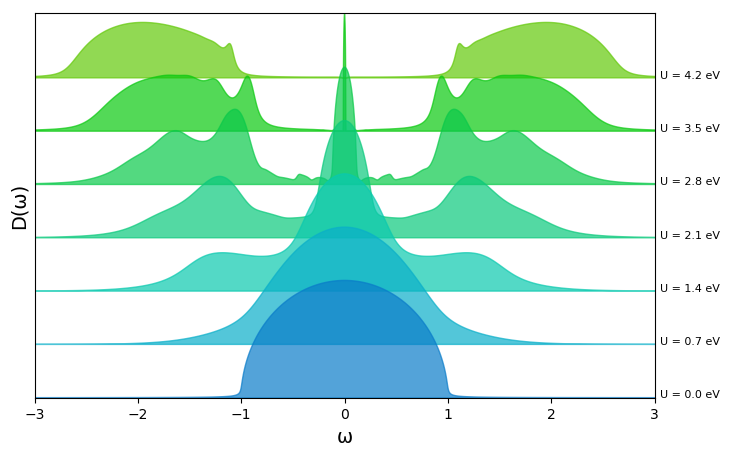

In [7]:
plt.figure(figsize=(8,5))
color = ["#0A7CC9","#0AAFC9","#0AC9AF","#0AC97C","#0AC94A","#0AC910","#63C90A"]
for iU in length(U):-1:1
    plt.plot(ω,vec(-imag(sum(glocr[:,:,iU],dims=2))) .+ (iU-1)*1.8,linewidth=0.0)
    plt.text(3.05,(iU-1)*1.8,"U = $(U[iU]) eV",fontsize=8)
    plt.fill_between(ω,vec(-imag(sum(glocr[:,:,iU],dims=2)).+ (iU-1)*1.8),(iU-1)*1.8,alpha=0.7,color=color[iU])
end

plt.xlim(-3,3)
plt.ylim(0,13)
plt.yticks([])
plt.xlabel("ω",fontsize=14)
plt.ylabel("D(ω)",fontsize=14)
plt.show()

plt.savefig("evolUDOS_IPT.pdf",format="pdf")

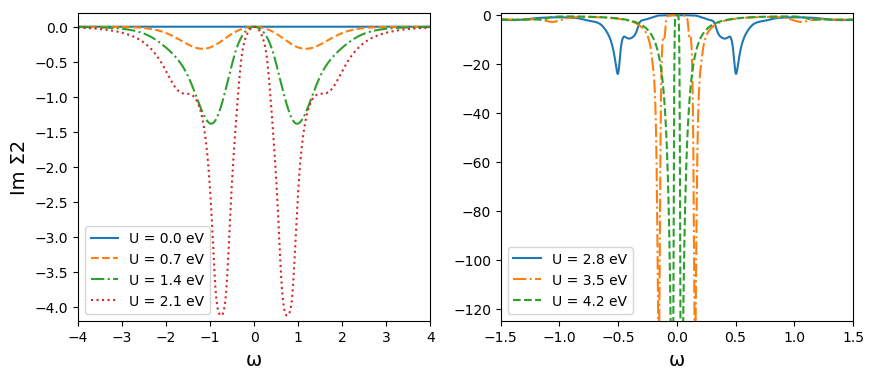

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
dashtype = ["-","--","-.",":"]
for iU in 1:4
    plt.plot(ω,imag(sum(Σ2[:,:,iU],dims=2)),dashtype[iU],label="U = $(U[iU]) eV")
end
plt.ylim(-4.2,0.2)
plt.xlim(-4,4.)
plt.ylabel("Im Σ2",fontsize=14)
plt.xlabel("ω",fontsize=14)
plt.legend()

plt.subplot(1, 2, 2)
dashtype = ["-","-.","--",":"]
for iU in 5:nU
    plt.plot(ω,imag(sum(Σ2[:,:,iU],dims=2)),dashtype[iU-4],label="U = $(U[iU]) eV")
end
plt.ylim(-125,1)
plt.xlim(-1.5,1.5)
plt.xlabel("ω",fontsize=14)
plt.legend()

plt.show()
plt.savefig("evolUΣ2_IPT.pdf",format="pdf")

In [9]:
U = 2.8

T = range(355., length=5,stop=360.)
T = convert(Array{Float64},T)
nT = length(T)

glocr = zeros(ComplexF64,(nω,2,nT))
Σ2 = zeros(ComplexF64,(nω,2,nT))
magnet = zeros(Float64,nT)

for (iT,Tx) in enumerate(T)
    glocr[:,:,iT],Σ1,Σ2[:,:,iT],magnet[iT] =  ipt_selfcons(ω,gloc,D0ω,t,U,Tx,itermax,nω,zeroplus,mix,tol)
end

Convergent is achieved for U = 2.8, and T = 355.0 K
Convergent is achieved for U = 2.8, and T = 356.25 K
Convergent is achieved for U = 2.8, and T = 357.5 K
Convergent is achieved for U = 2.8, and T = 358.75 K
Convergent is achieved for U = 2.8, and T = 360.0 K


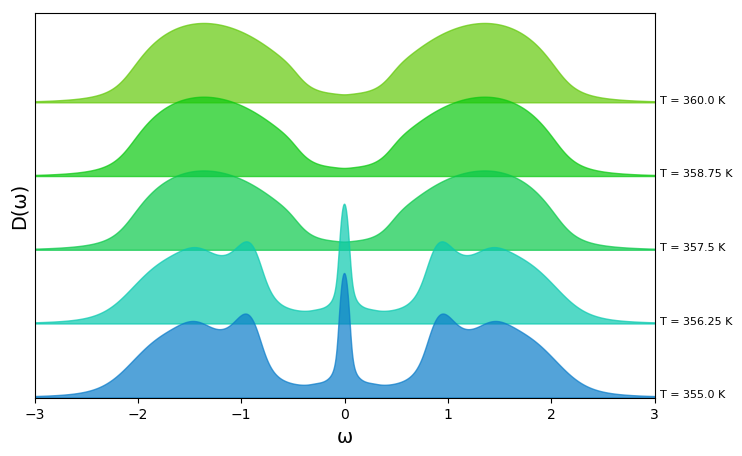

In [10]:
plt.figure(figsize=(8,5))
color = ["#0A7CC9","#0AC9AF","#0AC94A","#0AC910","#63C90A"]
for iT in length(T):-1:1
    plt.plot(ω,vec(-imag(sum(glocr[:,:,iT],dims=2))) .+ (iT-1)*1.8,linewidth=0.0)
    plt.text(3.05,(iT-1)*1.8,"T = $(T[iT]) K",fontsize=8)
    plt.fill_between(ω,vec(-imag(sum(glocr[:,:,iT],dims=2)).+ (iT-1)*1.8),(iT-1)*1.8,alpha=0.7,color=color[iT])
end

plt.xlim(-3,3)
plt.ylim(0,9.4)
plt.yticks([])
plt.xlabel("ω",fontsize=14)
plt.ylabel("D(ω)",fontsize=14)
plt.show()

plt.savefig("evolTDOS_IPT.pdf",format="pdf")

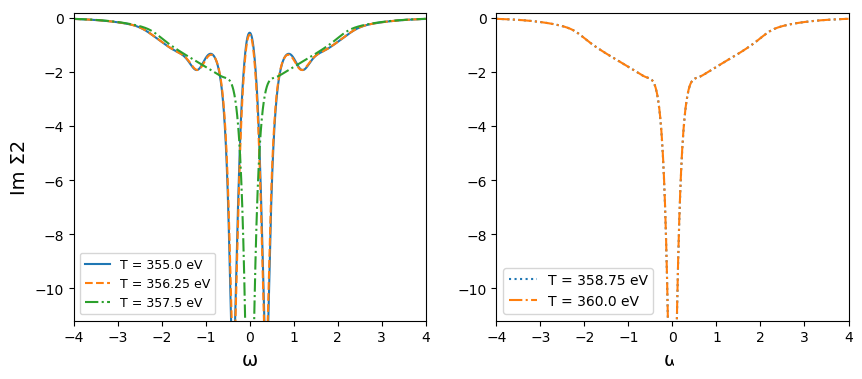

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
dashtype = ["-","--","-.",":","-."]
for iT in 1:3
    plt.plot(ω,imag(sum(Σ2[:,:,iT],dims=2)),dashtype[iT],label="T = $(T[iT]) eV")
end
plt.ylim(-11.2,0.2)
plt.xlim(-4,4.)
plt.ylabel("Im Σ2",fontsize=14)
plt.xlabel("ω",fontsize=14)
plt.legend(loc="lower left",fontsize=9)

plt.subplot(1, 2, 2)
dashtype = ["-","--","-.",":","-."]
for iT in 4:5
    plt.plot(ω,imag(sum(Σ2[:,:,iT],dims=2)),dashtype[iT],label="T = $(T[iT]) eV")
end
plt.ylim(-11.2,0.2)
plt.xlim(-4,4.)
plt.xlabel("ω",fontsize=14)
plt.legend(loc="lower left",fontsize=10)

plt.show()
plt.savefig("evolTΣ2_IPT.pdf",format="pdf")